In [0]:
import requests
from bs4 import BeautifulSoup
import re
import json
import sys
import time
import pandas as pd
from pandas import DataFrame
from tqdm.notebook import tqdm #소스코드 진행 확인

# from ppring import pprint # pretty print 이쁘게 출력하기 ppring(출력대상, indent=4)

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
nations = {
    'KOR' : '303,304,307,312,316,326,321,322,337,329,328,331,332',
    'EU' : '362,349,371,376,413,422,618,367,459,394,399,381,440,436,445,404,408,409,390,385,622',
    'JP/CN' : '491,486,500,514,509',
    'NA' : '569,573,611,587,546'    
}

In [0]:
for year in [2018, 2019, 2020]:
# for year in ['2020'] :
    dict_car = {
            'model' : [],
            'sales' : [],
            'segment' : [],
            'brand' : [],
            'price_min' : [],
            'price_max' : [],
            'spec_min' : [],
            'spec_max' : [],
            'release_date' : [],
            'date' : [],
            'nation_code' : []    
            }
    for month in range(1, 13) :
#     for month in range(1, 2) :
        
        if len(str(month)) == 1 :
            month = '0' + str(month)
#             month = int(month)
            print('month : ',month)
            
        if year == '2020' and month == '05' :
            break            
                    
        for nation in ['KOR','EU', 'JP/CN', 'NA'] :
        
            print('========================================================================================')
            print()
            print('YEAR : {}, MONTH : {}'.format(year, month))

            url ='http://auto.danawa.com/newcar'
            query = {
                'Work' : 'record',
                'Brand' : nations[nation],
                'Month' : '{}-{}-00'.format(year, month),
                'MonthTo' : ''
                } 
            
            print(nation)
            print(query['Month'])
            
            
            

            header = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36',
                        'referer': 'https://comic.naver.com/comment/comment.nhn?titleId=183559&no=485'}
            resp = requests.get(url, query, headers=header)        

            soup = BeautifulSoup(resp.content, 'lxml')                          
            tr_tag = soup.select('div.recordSection table.recordTable.model tbody tr')
            # _td_tag = soup.select('div.recordSection table.recordTable.model tbody tr td')        
            print(len(tr_tag))

            # for tr in tr_tag[46:47] :
            for idx, tr in enumerate(tr_tag):
                
#                 if year == '2019' and month == 2 and nation == 'EU' and idx == :
                
                # 차이름
                car_name_tag = tr.select('td.title a img')
                # print(car_name_tag)
                # print(len(car_name_tag))
                if len(car_name_tag) == 0 :
                    continue
                else :
                    name = car_name_tag[0]['alt']

                if '단종' in name:
                    continue
                elif '버스' in name:
                    continue 
                elif '특수' in name:
                    continue
                elif '크루즈' in name:
                    continue
                elif '기타' in name:
                    continue
                elif 'GT' in name:
                    continue    
                elif 'ED' in name:
                    continue
                elif 'QX50' in name:
                    continue
                elif '출시' in name:
                    continue
                elif '예정' in name:
                    continue
                elif 'All New Aviator' in name:
                    continue
                    

                # 판매량
                sales_rate_tag = tr.select('td.num')
                # print(sales_rate_tag[0].text)
                sales_rate = re.findall('[0-9,]+',sales_rate_tag[0].text)[0]

                # 링크
                href_tag = tr.select('td.title a')
                link = href_tag[0]['href']
                
                if link == '/auto/?Work=model&Model=3539' :
                    continue

                # 새로운 url
                new_url = 'http://auto.danawa.com' + link

                header = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36',
                        'referer': 'https://comic.naver.com/comment/comment.nhn?titleId=183559&no=485'}
                resp_ = requests.get(new_url, headers=header)
                soup_ = BeautifulSoup(resp_.content, 'lxml')

                # 브랜드 이름
                brand_tag = soup_.select('li.depth3.useSub a')
                brand_name = brand_tag[0].text

                # 차종
                category_tag = soup_.select('li.depth4.useSub a')
                category = category_tag[0].text

                # 가격(최고, 최저)
                price_tag = soup_.select('div.price_title span.num')
                # print(price_tag[0].text)
                price = re.findall('[0-9,]+',price_tag[0].text)
                # print(price[0], price[1])
                if len(price) == 2 :
                    price_low = price[0]
                    price_high = price[1]
                elif len(price) == 1 :
                    price_low = price[0]
                    price_high = price[0]

                # 출시일
                release_date_tag = soup_.select('div.date')
                # print(release_date_tag[0].text)
                release_date = re.findall('[0-9.]+',release_date_tag[0].text)[0]

                # 연비
                fuel_efficiency_tag = soup_.select('div.spec span.num')
                if len(fuel_efficiency_tag) == 0 :
                    fule_efficiency_low = ''
                    fule_efficiency_high = ''
                else :
                    # print(fuel_efficiency_tag[0].text)
                    fuel_efficiency = re.findall('[0-9.]+', fuel_efficiency_tag[0].text)
                    if len(fuel_efficiency) == 2:
                        fule_efficiency_low = fuel_efficiency[0]
                        fule_efficiency_high = fuel_efficiency[1]
                    elif len(fuel_efficiency) == 1:
                        fule_efficiency_low = fuel_efficiency[0]
                        fule_efficiency_high = fuel_efficiency[0]

                print('{} {} {} {} {} {} {} {} {} {} {}'.format(idx, name, sales_rate, link, brand_name, category, price_low, price_high, release_date, fule_efficiency_low, fule_efficiency_high))
                
                date = str(year) + '-' + str(month)
                
                na_code = 0
                
                if nation == 'KOR':
                    na_code = 1
                elif nation == 'EU':
                    na_code = 2
                elif nation == 'JP/CN':
                    na_code = 3
                elif nation == 'NA':
                    na_code = 4
                
                
                data = [name, sales_rate, category, brand_name, price_low, price_high, fule_efficiency_low, fule_efficiency_high, release_date, date, na_code]
                
                
                dict_car['model'].append(data[0])
                dict_car['sales'].append(data[1])
                dict_car['segment'].append(data[2])
                dict_car['brand'].append(data[3])
                dict_car['price_min'].append(data[4])
                dict_car['price_max'].append(data[5])
                dict_car['spec_min'].append(data[6])
                dict_car['spec_max'].append(data[7])
                dict_car['release_date'].append(data[8])
                dict_car['date'].append(data[9])
                dict_car['nation_code'].append(data[10])


            print()
            # print('========================================================================================')

    df = pd.DataFrame(dict_car)
    print(df)
    df.to_csv('car_{}.csv.'.format(year), index=False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
182 엑센트 519 /auto/?Work=model&Model=2126 현대 소형 1,138 1,606 2010.11 13.1 14.1
186 QM3 456 /auto/?Work=model&Model=3507 르노삼성 소형SUV 2,180 2,523 2017.08 17.4 17.4
189 다마스 408 /auto/?Work=model&Model=2049 쉐보레 상용 988 1,028 2008.04 8.8 8.8
193 쏘울 EV (전기차) 399 /auto/?Work=model&Model=3148 기아 준중형 4,280 4,280 2014.04 5.2 5.2
196 이쿼녹스 385 /auto/?Work=model&Model=3552 쉐보레 중형SUV 2,899 3,875 2018.06 12.9 13.3
199 라보 323 /auto/?Work=model&Model=2052 쉐보레 상용 838 1,098 2008.04 8.6 8.6
206 벨로스터 312 /auto/?Work=model&Model=3547 현대 준중형 2,044 2,568 2018.02 12.6 13.1
210 쏘나타 뉴 라이즈 hybrid 302 /auto/?Work=model&Model=3482 현대 중형 2,854 3,299 2017.05 17.4 18.0
213 코란도 C 286 /auto/?Work=model&Model=3442 쌍용 중형SUV 2,369 2,940 2017.01 11.8 12.6
216 K5 하이브리드 280 /auto/?Work=model&Model=3595 기아 중형 2,847 3,330 2018.05 17.2 18.0
219 SM7 278 /auto/?Work=model&Model=3210 르노삼성 준대형 2,375 3,302 2014.09 8.6 9.1
224 i30 236 /auto/?Work=model&Model=3398 현대 준중형 2,319 2,492 2016.09 11.4 11.8
229

IndexError: ignored

In [0]:
# df = pd.DataFrame(dict_car)
# print(df)
# df.to_csv('car_{}___.csv.'.format(year), index=False)

In [0]:
# csv 호출
df_2018 = pd.read_csv('car_2018_.csv')
df_2019 = pd.read_csv('car_2019_.csv')
df_2020 = pd.read_csv('car_2020_.csv')
df_whole = pd.concat([df_2018, df_2019, df_2020], axis=0)

print(df_2018, df_2019, df_2020)
print(df_whole)

          model  sales segment  ... release_date     date nation_code
0           그랜저  7,662     준대형  ...      2016.11  2018-01           1
1           포터2  6,247      상용  ...      2004.01  2018-01           1
2           쏘렌토  5,906   중형SUV  ...      2017.07  2018-01           1
3           아반떼  5,677     준중형  ...      2015.09  2018-01           1
4     쏘나타 뉴 라이즈  5,230      중형  ...      2017.03  2018-01           1
...         ...    ...     ...  ...          ...      ...         ...
2448        XT5     25   대형SUV  ...      2016.11  2018-12           4
2449   Escalade     12   대형SUV  ...      2017.05  2018-12           4
2450     Mondeo      5      중형  ...      2015.03  2018-12           4
2451   Cherokee      1   중형SUV  ...      2014.08  2018-12           4
2452       Kuga      1   중형SUV  ...      2017.01  2018-12           4

[2453 rows x 11 columns]                 model  sales segment  ... release_date     date nation_code
0                 포터2  8,951      상용  ...      2004.01  20

In [0]:
left_df_2018 = df_2018[['model','segment','brand', 'spec_min', 'spec_max', 'release_date', 'date', 'nation_code']]
right_df_2018 = df_2018[['sales','price_min','price_max']].stack().str.replace(',', '').unstack().astype('float')
df_2018_ = pd.concat([left_df_2018, right_df_2018], axis=1)
print(df_2018_)

left_df_2019 = df_2019[['model','segment','brand', 'spec_min', 'spec_max', 'release_date', 'date', 'nation_code']]
right_df_2019 = df_2019[['sales','price_min','price_max']].stack().str.replace(',', '').unstack().astype('float')
df_2019_ = pd.concat([left_df_2019, right_df_2019], axis=1)
print(df_2019_)

left_df_2020 = df_2020[['model','segment','brand', 'spec_min', 'spec_max', 'release_date', 'date', 'nation_code']]
right_df_2020 = df_2020[['sales','price_min','price_max']].stack().str.replace(',', '').unstack().astype('float')
df_2020_ = pd.concat([left_df_2020, right_df_2020], axis=1)
print(df_2020_)

df_whole_ = pd.concat([df_2018_, df_2019_, df_2020_], axis=0)
print(df_whole_)

          model segment brand  ...   sales  price_min  price_max
0           그랜저     준대형    현대  ...  7662.0     2545.0     4350.0
1           포터2      상용    현대  ...  6247.0     1549.0     4274.0
2           쏘렌토   중형SUV    기아  ...  5906.0     2695.0     3807.0
3           아반떼     준중형    현대  ...  5677.0     1394.0     2415.0
4     쏘나타 뉴 라이즈      중형    현대  ...  5230.0     1860.0     2293.0
...         ...     ...   ...  ...     ...        ...        ...
2448        XT5   대형SUV   캐딜락  ...    25.0     6537.0     7337.0
2449   Escalade   대형SUV   캐딜락  ...    12.0    12837.0    13837.0
2450     Mondeo      중형    포드  ...     5.0     4240.0     4240.0
2451   Cherokee   중형SUV    지프  ...     1.0     5070.0     5510.0
2452       Kuga   중형SUV    포드  ...     1.0     3930.0     4480.0

[2453 rows x 11 columns]
                model segment brand  ...   sales  price_min  price_max
0                 포터2      상용    현대  ...  8951.0     1549.0     4274.0
1                 그랜저     준대형    현대  ...  7627.0    

groupby 테스트

In [0]:
# cols = df_2018.columns
# print(cols)
cols = ['sales','model', 'segment', 'brand', 'nation_code', 'date']
df_tmp = df_2018[cols].groupby(['model', 'segment', 'brand', 'nation_code', 'date']).sum()
df_tmp.to_csv('df_2018_groupby.csv')

In [0]:
df_2018.shape

(2453, 11)

### Min-Max Scaler



In [0]:
from sklearn.preprocessing import MinMaxScaler
# def norm(x) :
#     _max = x.max()
#     _min = x.min()
#     _demon = _max - _min
#     return (x - _min) / _denom

In [0]:
# 지표 csv read
df_index =  pd.read_csv('data_.csv')
df_index = df_index.rename(columns={'Unnamed: 0':'date'})
df_index = df_index.rename(columns={'금리':'interest_rate'})
# df_index 
cols = ['date', 'KOSPI', 'DALLA', 'WTI', 'interest_rate']

# origin bak
df_index_orgin = df_index[cols]

df_index_ = df_index[cols]  # ['date', 'KOSPI', 'DALLA', 'WTI', 'interest_rate']
df_index_

,date,KOSPI,DALLA,WTI,interest_rate
0,2018-01,2520.937727,1068.209091,63.659048,1.50
1,2018-02,2439.104444,1081.222222,62.183684,1.50
2,2018-03,2451.570000,1071.819048,62.778571,1.50
3,2018-04,2458.224762,1069.142857,66.325238,1.50
4,2018-05,2461.300500,1077.795000,69.983182,1.50
5,2018-06,2394.507895,1096.931579,67.298571,1.50
6,2018-07,2284.253636,1124.100000,70.581905,1.50
7,2018-08,2283.796818,1121.613636,67.779565,1.50
8,2018-09,2307.325882,1121.147059,70.059474,1.50
9,2018-10,2153.476667,1133.323810,70.766087,1.50


In [0]:
# Min-Max 적용된 경제 지표 테이블
cols = ['KOSPI', 'DALLA', 'WTI', 'interest_rate']

df_date = df_index_[['date']]
df_ = df_index_[cols]

min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(df_)
df_index_min_max = min_max_scaler.transform(df_)
df_index_min_max = pd.DataFrame(df_index_min_max, columns=df_.columns, index=list(df_.index.values))

df_index_mm = pd.concat([df_date, df_index_min_max], axis =1)
df_index_mm

,date,KOSPI,DALLA,WTI,interest_rate
0,2018-01,1.000000,0.000000,0.868551,0.75
1,2018-02,0.888540,0.083556,0.841264,0.75
2,2018-03,0.905518,0.023179,0.852266,0.75
3,2018-04,0.914582,0.005996,0.917864,0.75
4,2018-05,0.918772,0.061550,0.985520,0.75
5,2018-06,0.827797,0.184425,0.935866,0.75
6,2018-07,0.677626,0.358871,0.996593,0.75
7,2018-08,0.677004,0.342906,0.944763,0.75
8,2018-09,0.709052,0.339910,0.986931,0.75
9,2018-10,0.499502,0.418096,1.000000,0.75


## 6. 국산/외산 월별 자동차 판매량과 경제지표 사이의 상관 관계 분석
- nation_code (1: KOR, 2: EU, 3: JP/CN, 4: NA)
- ['sales','nation_code', 'date'] 칼럼을 뽑은 데이터 프레임에서  ['nation_code', 'date'] 로 groupby하고 .sum()을 이용해 지역별 월별 판매량을 얻는다

### Merge() 사용 
- 지표 데이터(data.csv)가 있는 DataFrame에서 월별 '코스피', '환율','WTI','금리' 와 월별 판매량 사이의 상관 관계를 구하기 위해서 두 데이터 프레임을 merge() 하였음 

In [0]:
# 2018년 데이터
df_2018_tmp = df_2018_[['sales','nation_code', 'date']].groupby(['nation_code', 'date'], as_index=False).sum()
# print(df_2018_tmp)

df_kor_sales = df_2018_tmp[['sales']].iloc[0:12]
# print(df_kor_sales)

2018년 경제지표와 국산차 판매량 상관관계
                  sales     KOSPI     DALLA       WTI  interest_rate
sales          1.000000 -0.502905  0.311757 -0.193097       0.419541
KOSPI         -0.502905  1.000000 -0.894971  0.432001      -0.749090
DALLA          0.311757 -0.894971  1.000000 -0.056926       0.433000
WTI           -0.193097  0.432001 -0.056926  1.000000      -0.852508
interest_rate  0.419541 -0.749090  0.433000 -0.852508       1.000000


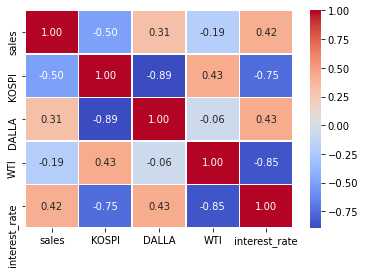

In [0]:
# 2018년 경제지표와 국산차 판매량 상관관계
df_kor_ = df_2018_tmp[['date','sales']][0:12]

df_index_mm_2018 = df_index_mm.iloc[0:12] 

df_kor_corr = pd.merge(df_kor_, df_index_mm_2018, on='date')
print('2018년 경제지표와 국산차 판매량 상관관계')
# print(df_kor_corr)
# print()
print(df_kor_corr.corr())
sns.heatmap(df_kor_corr.corr(), cmap='coolwarm', annot=True, fmt = '.2f', annot_kws={'size' : 10}, lw=0.5)
plt.show()

In [0]:
# 2018년 경제지표와 외산차 판매량 상관관계
df_others_sales = df_2018_tmp[['date','sales']].iloc[12:48].groupby(['date'], as_index=False).sum()
df_index_mm_2018 = df_index_mm.iloc[0:12] 

df_others_corr = pd.merge(df_others_sales, df_index_mm_2018, on='date')
print('2018년 경제지표와 외산차 판매량 상관관계')
# print(df_kor_corr)
# print()
print(df_others_corr.corr())
sns.heatmap(df_others_corr.corr(), cmap='coolwarm', annot=True, fmt = '.2f', annot_kws={'size' : 10}, lw=0.5)
plt.show()

2018년 경제지표와 외산차 판매량 상관관계
                  sales     KOSPI     DALLA       WTI  interest_rate
sales          1.000000  0.369335 -0.610035 -0.092528      -0.047205
KOSPI          0.369335  1.000000 -0.894971  0.432001      -0.749090
DALLA         -0.610035 -0.894971  1.000000 -0.056926       0.433000
WTI           -0.092528  0.432001 -0.056926  1.000000      -0.852508
interest_rate -0.047205 -0.749090  0.433000 -0.852508       1.000000


In [0]:
# 2019년 데이터
df_2019_tmp = df_2019_[['sales','nation_code', 'date']].groupby(['nation_code', 'date'], as_index=False).sum()
# print(df_2018_tmp)

df_kor_sales = df_2019_tmp[['sales']].iloc[0:12]
# print(df_kor_sales)

2019년 경제지표와 국산차 판매량 상관관계
                  sales     KOSPI     DALLA       WTI  interest_rate
sales          1.000000  0.180309  0.126260  0.557450      -0.404783
KOSPI          0.180309  1.000000 -0.791667  0.406678       0.305096
DALLA          0.126260 -0.791667  1.000000  0.058363      -0.519029
WTI            0.557450  0.406678  0.058363  1.000000       0.069203
interest_rate -0.404783  0.305096 -0.519029  0.069203       1.000000


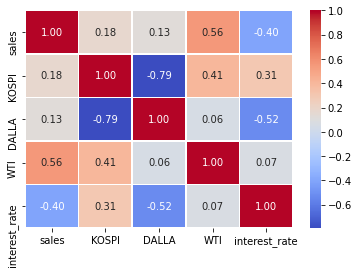

In [0]:
# 2019년 경제지표와 국산차 판매량 상관관계
df_kor_ = df_2019_tmp[['date','sales',]][0:12]

df_index_mm_2019 = df_index_mm.iloc[12:24] 
# print(df_kor_)

df_kor_corr = pd.merge(df_kor_, df_index_mm_2019, on='date')
print('2019년 경제지표와 국산차 판매량 상관관계')
# print(df_kor_corr)
# print()
print(df_kor_corr.corr())
sns.heatmap(df_kor_corr.corr(), cmap='coolwarm', annot=True, fmt = '.2f', annot_kws={'size' : 10}, lw=0.5)
plt.show()

2019년 경제지표와 외산차 판매량 상관관계
                  sales     KOSPI     DALLA       WTI  interest_rate
sales          1.000000 -0.017229  0.353248  0.205339      -0.789433
KOSPI         -0.017229  1.000000 -0.791667  0.406678       0.305096
DALLA          0.353248 -0.791667  1.000000  0.058363      -0.519029
WTI            0.205339  0.406678  0.058363  1.000000       0.069203
interest_rate -0.789433  0.305096 -0.519029  0.069203       1.000000


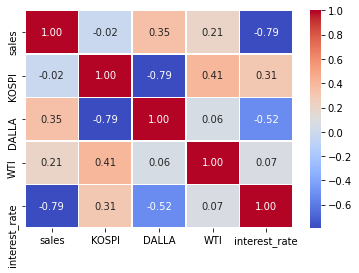

In [0]:
# 2019년 경제지표와 외산차 판매량 상관관계
df_others_sales = df_2019_tmp[['date','sales']].iloc[12:48].groupby(['date'], as_index=False).sum()
df_index_mm_2019 = df_index_mm.iloc[12:24] 

df_others_corr = pd.merge(df_others_sales, df_index_mm_2019, on='date')
print('2019년 경제지표와 외산차 판매량 상관관계')
# print(df_kor_corr)
# print()
print(df_others_corr.corr())
sns.heatmap(df_others_corr.corr(), cmap='coolwarm', annot=True, fmt = '.2f', annot_kws={'size' : 10}, lw=0.5)
plt.show()

In [0]:
# 2020년 데이터
df_2020_tmp = df_2020_[['sales','nation_code', 'date']].groupby(['nation_code', 'date'], as_index=False).sum()
# print(df_2018_tmp)

df_kor_sales = df_2020_tmp[['sales']].iloc[0:12]
# print(df_kor_sales)

2020년 경제지표와 국산차 판매량 상관관계
                  sales     KOSPI     DALLA       WTI  interest_rate
sales          1.000000 -0.183338  0.150540 -0.168975      -0.187301
KOSPI         -0.183338  1.000000 -0.912021  0.906928       0.990369
DALLA          0.150540 -0.912021  1.000000 -0.927805      -0.896823
WTI           -0.168975  0.906928 -0.927805  1.000000       0.941459
interest_rate -0.187301  0.990369 -0.896823  0.941459       1.000000


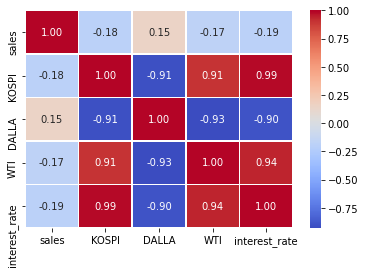

In [0]:
# 2020년 경제지표와 국산차 판매량 상관관계
df_kor_ = df_2020_tmp[['date','sales',]][0:12]

df_index_mm_2020 = df_index_mm.iloc[24:] 
# print(df_kor_)

df_kor_corr = pd.merge(df_kor_, df_index_mm_2020, on='date')
print('2020년 경제지표와 국산차 판매량 상관관계')
# print(df_kor_corr)
# print()
print(df_kor_corr.corr())
sns.heatmap(df_kor_corr.corr(), cmap='coolwarm', annot=True, fmt = '.2f', annot_kws={'size' : 10}, lw=0.5)
plt.show()

2020년 경제지표와 외산차 판매량 상관관계
                  sales     KOSPI     DALLA       WTI  interest_rate
sales          1.000000 -0.436947  0.123897 -0.437612      -0.525842
KOSPI         -0.436947  1.000000 -0.912021  0.906928       0.990369
DALLA          0.123897 -0.912021  1.000000 -0.927805      -0.896823
WTI           -0.437612  0.906928 -0.927805  1.000000       0.941459
interest_rate -0.525842  0.990369 -0.896823  0.941459       1.000000


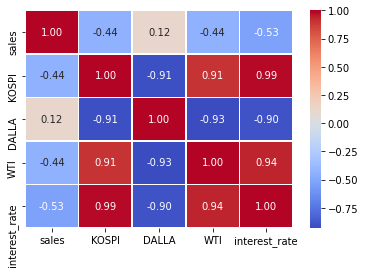

In [0]:
# 2020년 경제지표와 외산차 판매량 상관관계
df_others_sales = df_2020_tmp[['date','sales']].iloc[12:48].groupby(['date'], as_index=False).sum()
df_index_mm_2020 = df_index_mm.iloc[24:] 

df_others_corr = pd.merge(df_others_sales, df_index_mm_2020, on='date')
print('2020년 경제지표와 외산차 판매량 상관관계')
# print(df_kor_corr)
# print()
print(df_others_corr.corr())
sns.heatmap(df_others_corr.corr(), cmap='coolwarm', annot=True, fmt = '.2f', annot_kws={'size' : 10}, lw=0.5)
plt.show()